In [1]:
import sys, os, pygmt, importlib, re
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_processor          import SeaIceProcessor
from sea_ice_plotter            import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor
from datetime                   import timedelta, date, datetime
from pathlib                    import Path
from dask.distributed           import Client, LocalCluster
import numpy                    as np
import pandas                   as pd
import xarray                   as xr
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, TextArea
# import xesmf                    as xe
# import matplotlib.pyplot        as plt
# import matplotlib.dates         as mdates

In [106]:
# Import module *objects* first
import sea_ice_processor
import sea_ice_plotter
import grounded_iceberg_processor
# Reload them if they were edited
importlib.reload(sea_ice_processor)
importlib.reload(sea_ice_plotter)
importlib.reload(grounded_iceberg_processor)
# Then (re)import the classes from the reloaded modules
from sea_ice_processor          import SeaIceProcessor
from sea_ice_plotter            import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor

# grounded icebergs

In [ ]:
GI_proc = GroundedIcebergProcessor()
GI_proc.process_raw_grounded_iceberg_database()
GI_proc.modify_landmask_with_grounded_icebergs(p_min=0.1, p_max=0.9, scaling_exponent=.35)

In [ ]:
GI_proc.write_modified_landmask_and_counts_to_disk(write=True, overwrite=True)

In [ ]:
SP = SeaIcePlotter(ice_type='GI', sim_name='baseline', show_fig = True, save_fig = True, )
KMT1 = xr.open_dataset("/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50_POSSIBLE_ERROR.nc")
KMT2 = xr.open_dataset("/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50.nc")
SP.plot_sectors_grounded_icebergs(KMT2=KMT2,save_dir="0p25", filename_extras="POSSIBLE-ERRORS_v_Revised")

In [ ]:
P_kmt_mod = "/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50.nc"
P_kmt_org = "/g/data/gv90/da1339/grounded_icebergs/MyThin_db/KMT_original_reformatted_with_coordinates.nc"
ds_mod    = xr.open_dataset(P_kmt_mod)
ds_org    = xr.open_dataset(P_kmt_org)
kmt_mod   = ds_mod['kmt'].values
kmt_org   = ds_org['kmt'].values
lat       = ds_mod['lat']
lon       = ds_mod['lon']
dlon      = np.mean(np.diff(lon.values[0]))  # assumes regular grid in ni dimension
print("MOD KMT LAND CELL COUNT:", np.sum(kmt_mod == 1))
print("ORG KMT LAND CELL COUNT:", np.sum(kmt_org == 1))
print("Total mismatches:", np.sum(kmt_mod != kmt_org))
print("Unique values in KMT MODIFIED:", np.unique(kmt_mod))
print("Unique values in KMT ORIGINAL:", np.unique(kmt_org))
assert kmt_mod.shape == kmt_org.shape == lat.shape == lon.shape
# Get indices of mismatch
mask_diff = (kmt_org==1) & (kmt_mod!=1)
ji_diff = np.where(mask_diff)  # ji_diff = (j indices, i indices)
# Shift i (longitude) index one cell west
j_idx, i_idx = ji_diff
i_idx_shifted = i_idx - 1  # move one cell west
# Remove invalid (negative) i indices
valid_mask = i_idx_shifted >= 0
j_idx = j_idx[valid_mask]
i_idx = i_idx_shifted[valid_mask]
# Extract adjusted coordinates
lat_diff = lat.values[j_idx, i_idx]
lon_diff = lon.values[j_idx, i_idx]

In [ ]:
KMT_mod = 

# process for fast ice using SeaIceProcessor()

In [ ]:
cluster = LocalCluster(n_workers=28, threads_per_worker=1, memory_limit='6GB')
client = Client(cluster)
print("✅ Dask dashboard:", client.dashboard_link)

In [12]:
sim_name  = "elps-max"
ispd_thresh = 1.0e-3
ice_type    = "FI_BT"
ispd_str = f"{ispd_thresh:.1e}".replace("e-0", "e-")
smooth_FIA_days = 15
overwrite_zarr = False
compute_boolean = True
overwrite_png   = True
SI_proc  = SeaIceProcessor(sim_name = sim_name)
SI_plot  = SeaIcePlotter(sim_name  = sim_name,
                         ice_type  ='FI', 
                         plot_type = 'timeseries',
                         var_name  = 'FIA',
                         show_fig  = False,
                         save_fig  = True,
                         overwrite = True)
dt0_str, dtN_str = SI_proc.sim_config['dt0_str'], SI_proc.sim_config['dtN_str']
dt_range_str     = f"{dt0_str[:4]}-{dtN_str[:4]}"
cfg              = SI_proc.sim_config
ktens, elps, GI_thin = cfg.get("Ktens", "?"), cfg.get("e_f", "?"), 1 - cfg.get("GI_thin_fact", 0)
ice_types = [ice_type] if isinstance(ice_type, str) else list(ice_type)
D_out = Path(SI_proc.config['D_dict']['AFIM_out'], sim_name, "zarr", f"ispd_thresh_{ispd_str}", "metrics")
D_out.mkdir(parents=True, exist_ok=True)
FIA_comp, FIP_comp = {}, {}
obs_clim = None
af2020_df = pd.read_csv(SI_proc.sea_ice_dict['P_AF2020_cli_csv'])
obs_clim  = SI_proc.interpolate_obs_fia(af2020_df)
obs_min   = obs_clim.min().values
obs_max   = obs_clim.max().values

2025-05-30 09:17:55,624 - INFO - log file intialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_elps-max.log
INFO:elps-max:log file intialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_elps-max.log
2025-05-30 09:17:56,238 - INFO - hemisphere initialised: south
INFO:elps-max:hemisphere initialised: south
2025-05-30 09:17:56,250 - INFO - Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
INFO:elps-max:Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
2025-05-30 09:17:56,251 - INFO - Median grid cell length below -60°: 10365.7 m
INFO:elps-max:Median grid cell length below -60°: 10365.7 m
2025-05-30 09:17:56,253 - INFO - → Displacement                             = 0.42% of grid cell per day
INFO:elps-max:→ Displacement                             = 0.42% of grid cell per day
2025-05-30 09:17:56,254 - INFO - → Days to fully traverse one grid cell     : 239.95 days
INFO:elps-max:→ Days to fully traverse one grid cell     : 239.95 days


583 circumpolar grounded icebergs associated with elps-max
66791608021.64 m^2 total circumpolar grounded iceberg area for elps-max
583 circumpolar grounded icebergs associated with elps-max
66791608021.64 m^2 total circumpolar grounded iceberg area for elps-max


In [44]:
def plot_cice_field(x1, y1, z1, title, region, 
                    cmap="cmocean/haline", cmap_series=[0.9, 1],
                    GI_coords=None, GI_color="red", 
                    var_style="s0.5c", GI_style="c0.3c", 
                    projection="S75/-90/30c", 
                    cbar_label="sea ice concentration", units="1/100"):
    fig = pygmt.Figure()
    pygmt.config(FORMAT_GEO_MAP="ddd.x", FONT_TITLE="16p,Courier-Bold", FONT_ANNOT_PRIMARY="14p,Helvetica")
    pygmt.makecpt(cmap=cmap, series=cmap_series)
    fig.basemap(projection=projection, region=region, frame=["af", f"+t{title}"])
    fig.plot(x=x1, y=y1, fill=z1, cmap=True, style=var_style)
    if GI_coords:
        fig.plot(x=GI_coords[0], y=GI_coords[1], fill=GI_color, style=GI_style)
    fig.coast(land='gray')
    fig.colorbar(position="JBC+o0c/1.5c", frame=[f"x+l{cbar_label}", f"y+l{units}"])
    return fig

def plot_persistence_map(DA, sim_name, itype, ispd_str, ktens, elps, GI_thin, SI_plot, dt_range_str, overwrite_png):
    da   = DA.values.ravel()
    lon  = DA["TLON"].values.ravel()
    lat  = DA["TLAT"].values.ravel()
    mask = ~np.isnan(da)
    lat_plt, lon_plt, da_plt = lat[mask], lon[mask], da[mask]
    for reg_name, reg_cfg in SI_plot.reg_dict.items():
        D_plt = Path(SI_plot.D_graph, sim_name, reg_name, "FIP", f"ispd_thresh_{ispd_str}", itype)
        D_plt.mkdir(parents=True, exist_ok=True)
        P_plt = Path(D_plt,f"FIP_{dt_range_str}.png")
        if P_plt.exists() and not overwrite_png:
            print(f"figure {P_plt} exists and not overwriting")
            continue
        else:
            MC  = SI_plot.get_meridian_center_from_geographic_extent(reg_cfg['plt_ext'])
            fig = plot_cice_field(lon_plt, lat_plt, da_plt,
                                  f"{sim_name} {itype} ispd_thresh={ispd_str}: ktens={ktens}, elps={elps}, GI-thin={GI_thin:.2f}",
                                  region=reg_cfg['plt_ext'],
                                  cmap="/home/581/da1339/graphical/CPTs/AF2020_YlGnBu.cpt",
                                  cmap_series=[0, 1],
                                  GI_coords=(SI_plot.GI_proc.G_t['GI_lon'], SI_plot.GI_proc.G_t['GI_lat']),
                                  GI_color="red", var_style="s0.3c", GI_style="c0.1c", 
                                  projection=f"S{MC}/-90/30c", cbar_label="fast ice persistence")
            print(f"📸 Saving figure: {P_plt}")
            fig.savefig(P_plt)

def compute_and_save_metrics(SI_proc, DS_FI, P_METS, obs_clim=None):
    METS, summary           = {}, {}
    FIA                     = SI_proc.compute_ice_area(DS_FI['aice'], DS_FI['tarea']).compute()
    FIP                     = SI_proc.compute_variable_aggregate(DS_FI['aice']).compute()
    METS["FIA"]             = FIA
    METS["FIP"]             = FIP
    summary["onset_doy"]    = SI_proc.compute_fia_onset_doy(FIA)
    summary["growth_rate"]  = SI_proc.compute_fia_growth_rate(FIA)
    summary["max_growth"]   = SI_proc.compute_fia_max_growth(FIA)
    summary["doy_max"]      = SI_proc.compute_doy_max(FIA)
    summary["duration"]     = SI_proc.compute_fast_ice_duration(FIA)
    fip_mean, fip_std       = SI_proc.compute_fip_spatial_stats(FIP)
    summary["FIP_mean"]     = fip_mean
    summary["FIP_std"]      = fip_std
    mean_dist, max_dist     = SI_proc.compute_fast_ice_distance_extent(DS_FI['FI_mask'])
    summary["mean_FI_dist"] = mean_dist
    summary["max_FI_dist"]  = max_dist
    if obs_clim is not None:
        model_doy = FIA["time"].dt.dayofyear.values
        obs_vals = np.interp(model_doy, obs_clim.coords["doy"].values, obs_clim.values)
        summary["rmse_to_obs"] = SI_proc.compute_fia_rmse(FIA, xr.DataArray(obs_vals, coords=[("time", FIA["time"].data)]))
    for key, val in summary.items():
        if isinstance(val, dict):
            summary[key] = xr.DataArray(pd.Series(val), dims="year")
    DS_METS = xr.Dataset(summary)
    DS_METS["FIA"] = FIA
    DS_METS["FIP"] = FIP
    DS_METS.to_zarr(P_METS, mode="w", consolidated=True)
    print(f"📊 Metrics written to {P_METS}")
    return DS_METS

def save_metrics_csv(metrics_dict, sim_name, i_type, ispd_str, D_out):
    from pandas import DataFrame
    df = DataFrame([metrics_dict])
    df["sim_name"]     = sim_name
    df["ice_type"]     = i_type
    df["ispd_thresh"]  = ispd_str
    df.to_csv(Path(D_out, f"{i_type}_summary.csv"), index=False)

In [111]:
for itype in ['FI_BT','FI_Ta','FI_Tx','FI_B']:
    for roll in [False,True]:
        i_type = f"{itype}_roll" if roll else itype
        P_METS = Path(D_out, f"{i_type}_mets.zarr")
        if P_METS.exists() and not overwrite_zarr:
            print(f"{P_METS} exists and not overwriting--loading")
            METS = xr.open_zarr(P_METS)
        else:
            print(f"{P_METS} does NOT exists and/or overwriting--computing")
            DS_FI, CICE_SO = SI_proc.load_processed_cice(dt0_str     = dt0_str,
                                                         dtN_str     = dtN_str,
                                                         ispd_thresh = ispd_thresh,
                                                         ice_type    = itype,
                                                         zarr_CICE   = True,
                                                         rolling     = roll)
            if DS_FI is None: continue
            METS = compute_and_save_metrics(SI_proc, DS_FI, P_METS, obs_clim=obs_clim)
            save_metrics_csv(METS, sim_name=sim_name, i_type=i_type, ispd_str=ispd_str, D_out=D_out)
        FIA_comp[i_type] = METS['FIA']
        FIP_comp[i_type] = METS['FIP']
        plot_persistence_map(METS['FIP'], sim_name, i_type, ispd_str, ktens, elps, GI_thin, SI_plot, dt_range_str, False)
        if compute_boolean and not roll:
            P_METS, METS = None, None
            i_type = f"{itype}_bool"
            P_METS = Path(D_out,f"{i_type}_mets.zarr")
            if P_METS.exists() and not overwrite_zarr:
                print(f"{P_METS} exists and not overwriting--loading")
                METS = xr.open_zarr(P_METS)
            else:
                print(f"{P_METS} does NOT exists and/or overwriting--computing")
                bool_mask = SI_proc.boolean_fast_ice(DS_FI['FI_mask'], dim="time", window=7, min_count=6)
                DS_bool   = CICE_SO.where(bool_mask)
                DS_bool["FI_mask"] = DS_FI["FI_mask"]
                METS      = compute_and_save_metrics(SI_proc, DS_bool, P_METS, obs_clim=obs_clim)
                save_metrics_csv(METS, sim_name=sim_name, i_type=i_type, ispd_str=ispd_str, D_out=D_out)
            FIA_comp[i_type] = METS['FIA']
            FIP_comp[i_type] = METS['FIP']
            plot_persistence_map(METS['FIP'], sim_name, i_type, ispd_str, ktens, elps, GI_thin, SI_plot, dt_range_str, False)

/g/data/gv90/da1339/afim_output/ry93/zarr/ispd_thresh_1.0e-3/metrics/FI_BT_mets.zarr exists and not overwriting--loading
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/DML/FIP/ispd_thresh_1.0e-3/FI_BT/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/WIO/FIP/ispd_thresh_1.0e-3/FI_BT/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/EIO/FIP/ispd_thresh_1.0e-3/FI_BT/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/Aus/FIP/ispd_thresh_1.0e-3/FI_BT/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/VOL/FIP/ispd_thresh_1.0e-3/FI_BT/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/AS/FIP/ispd_thresh_1.0e-3/FI_BT/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/BS/FIP/ispd_thresh_1.0e-3/FI_BT/FIP_1993-1999.png exists and not overwriting
figure

2025-05-29 10:29:52,980 - INFO - 📁 Found 84 zarr files: ['cice_daily_1993-01.zarr', 'cice_daily_1993-02.zarr', 'cice_daily_1993-03.zarr', 'cice_daily_1993-04.zarr', 'cice_daily_1993-05.zarr', 'cice_daily_1993-06.zarr', 'cice_daily_1993-07.zarr', 'cice_daily_1993-08.zarr', 'cice_daily_1993-09.zarr', 'cice_daily_1993-10.zarr', 'cice_daily_1993-11.zarr', 'cice_daily_1993-12.zarr', 'cice_daily_1994-01.zarr', 'cice_daily_1994-02.zarr', 'cice_daily_1994-03.zarr', 'cice_daily_1994-04.zarr', 'cice_daily_1994-05.zarr', 'cice_daily_1994-06.zarr', 'cice_daily_1994-07.zarr', 'cice_daily_1994-08.zarr', 'cice_daily_1994-09.zarr', 'cice_daily_1994-10.zarr', 'cice_daily_1994-11.zarr', 'cice_daily_1994-12.zarr', 'cice_daily_1995-01.zarr', 'cice_daily_1995-02.zarr', 'cice_daily_1995-03.zarr', 'cice_daily_1995-04.zarr', 'cice_daily_1995-05.zarr', 'cice_daily_1995-06.zarr', 'cice_daily_1995-07.zarr', 'cice_daily_1995-08.zarr', 'cice_daily_1995-09.zarr', 'cice_daily_1995-10.zarr', 'cice_daily_1995-11.zarr'

figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/DML/FIP/ispd_thresh_1.0e-3/FI_Ta_roll/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/WIO/FIP/ispd_thresh_1.0e-3/FI_Ta_roll/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/EIO/FIP/ispd_thresh_1.0e-3/FI_Ta_roll/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/Aus/FIP/ispd_thresh_1.0e-3/FI_Ta_roll/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/VOL/FIP/ispd_thresh_1.0e-3/FI_Ta_roll/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/AS/FIP/ispd_thresh_1.0e-3/FI_Ta_roll/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/BS/FIP/ispd_thresh_1.0e-3/FI_Ta_roll/FIP_1993-1999.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/ry93/WS/FIP/ispd_thresh_1.0e-3/FI_Ta_roll/FIP_1993

2025-05-29 10:29:53,182 - WARNING - ⚠️ Skipping /g/data/gv90/da1339/afim_output/ry93/zarr/ispd_thresh_1.0e-3/cice_daily_1995-02.zarr (FI_Tx): 'FI_Tx'
2025-05-29 10:29:53,189 - WARNING - ⚠️ Skipping /g/data/gv90/da1339/afim_output/ry93/zarr/ispd_thresh_1.0e-3/cice_daily_1995-03.zarr (FI_Tx): 'FI_Tx'
2025-05-29 10:29:53,196 - WARNING - ⚠️ Skipping /g/data/gv90/da1339/afim_output/ry93/zarr/ispd_thresh_1.0e-3/cice_daily_1995-04.zarr (FI_Tx): 'FI_Tx'
2025-05-29 10:29:53,204 - WARNING - ⚠️ Skipping /g/data/gv90/da1339/afim_output/ry93/zarr/ispd_thresh_1.0e-3/cice_daily_1995-05.zarr (FI_Tx): 'FI_Tx'
2025-05-29 10:29:53,209 - WARNING - ⚠️ Skipping /g/data/gv90/da1339/afim_output/ry93/zarr/ispd_thresh_1.0e-3/cice_daily_1995-06.zarr (FI_Tx): 'FI_Tx'
2025-05-29 10:29:53,215 - WARNING - ⚠️ Skipping /g/data/gv90/da1339/afim_output/ry93/zarr/ispd_thresh_1.0e-3/cice_daily_1995-07.zarr (FI_Tx): 'FI_Tx'
2025-05-29 10:29:53,221 - WARNING - ⚠️ Skipping /g/data/gv90/da1339/afim_output/ry93/zarr/ispd_thres

TypeError: cannot unpack non-iterable NoneType object

In [21]:
sim_name  = "Cstar-max"
root      = Path(f"/home/581/da1339/AFIM_archive/{sim_name}/zarr")
fia_paths = sorted(root.glob("ispd_thresh_*/metrics/FI_BT_*_mets.zarr"))
fia_data  = defaultdict(lambda: {"FIA_min_vals": [], "FIA_max_vals": []})
for zarr_path in fia_paths:
    print(zarr_path)
    thresh_match = re.search(r"ispd_thresh_([0-9.e+-]+)", str(zarr_path))
    thresh       = float(thresh_match.group(1))
    ds           = xr.open_zarr(zarr_path)
    fia          = ds["FIA"]
    t0           = pd.to_datetime(fia["time"].values[0])
    fia_filtered = fia.isel(time=slice(365,-1))
    fia_vals     = fia_filtered.values
    fia_data[thresh]["FIA_min_vals"].append(float(np.percentile(fia_vals, 1.0)))
    fia_data[thresh]["FIA_max_vals"].append(float(fia.max()))
print(fia_data)

/home/581/da1339/AFIM_archive/Cstar-max/zarr/ispd_thresh_1.0e-3/metrics/FI_BT_bool_mets.zarr
/home/581/da1339/AFIM_archive/Cstar-max/zarr/ispd_thresh_1.0e-3/metrics/FI_BT_roll_mets.zarr
/home/581/da1339/AFIM_archive/Cstar-max/zarr/ispd_thresh_1.0e-4/metrics/FI_BT_bool_mets.zarr
/home/581/da1339/AFIM_archive/Cstar-max/zarr/ispd_thresh_1.0e-4/metrics/FI_BT_roll_mets.zarr
/home/581/da1339/AFIM_archive/Cstar-max/zarr/ispd_thresh_1.2e-3/metrics/FI_BT_bool_mets.zarr
/home/581/da1339/AFIM_archive/Cstar-max/zarr/ispd_thresh_1.2e-3/metrics/FI_BT_roll_mets.zarr
/home/581/da1339/AFIM_archive/Cstar-max/zarr/ispd_thresh_2.0e-4/metrics/FI_BT_bool_mets.zarr
/home/581/da1339/AFIM_archive/Cstar-max/zarr/ispd_thresh_2.0e-4/metrics/FI_BT_roll_mets.zarr
/home/581/da1339/AFIM_archive/Cstar-max/zarr/ispd_thresh_2.2e-2/metrics/FI_BT_bool_mets.zarr
/home/581/da1339/AFIM_archive/Cstar-max/zarr/ispd_thresh_2.2e-2/metrics/FI_BT_roll_mets.zarr
/home/581/da1339/AFIM_archive/Cstar-max/zarr/ispd_thresh_4.0e-4/metric

/home/581/da1339/AFIM_archive/ktens-nil/zarr/ispd_thresh_1.0e-3/metrics/FI_BT_bool_mets.zarr
/home/581/da1339/AFIM_archive/ktens-nil/zarr/ispd_thresh_1.0e-3/metrics/FI_BT_roll_mets.zarr
/home/581/da1339/AFIM_archive/ktens-nil/zarr/ispd_thresh_1.0e-4/metrics/FI_BT_bool_mets.zarr
/home/581/da1339/AFIM_archive/ktens-nil/zarr/ispd_thresh_1.0e-4/metrics/FI_BT_roll_mets.zarr
/home/581/da1339/AFIM_archive/ktens-nil/zarr/ispd_thresh_1.2e-3/metrics/FI_BT_bool_mets.zarr
/home/581/da1339/AFIM_archive/ktens-nil/zarr/ispd_thresh_1.2e-3/metrics/FI_BT_roll_mets.zarr
/home/581/da1339/AFIM_archive/ktens-nil/zarr/ispd_thresh_1.8e-3/metrics/FI_BT_bool_mets.zarr
/home/581/da1339/AFIM_archive/ktens-nil/zarr/ispd_thresh_1.8e-3/metrics/FI_BT_roll_mets.zarr
/home/581/da1339/AFIM_archive/ktens-nil/zarr/ispd_thresh_2.0e-4/metrics/FI_BT_bool_mets.zarr
/home/581/da1339/AFIM_archive/ktens-nil/zarr/ispd_thresh_2.0e-4/metrics/FI_BT_roll_mets.zarr
/home/581/da1339/AFIM_archive/ktens-nil/zarr/ispd_thresh_2.2e-2/metric

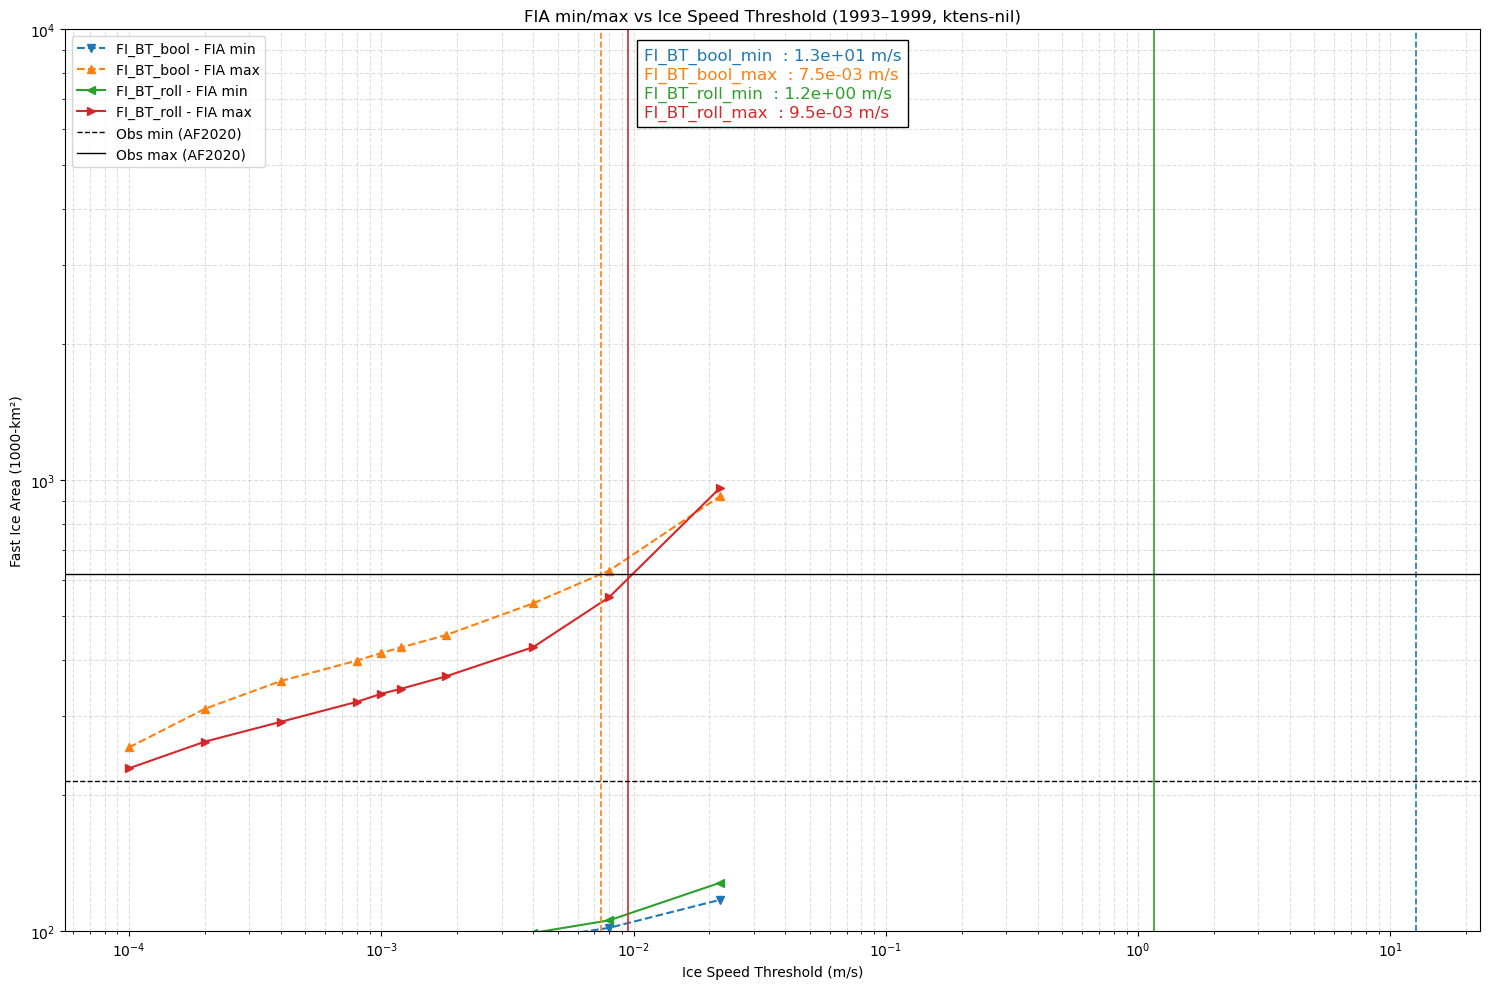

In [25]:
sim_name      = "ktens-nil"
intersections = {}
line_colors   = {}
annotated     = {"min": False, "max": False}
figsize       = (15,10)
root          = Path(f"/home/581/da1339/AFIM_archive/{sim_name}/zarr")
fia_paths     = sorted(root.glob("ispd_thresh_*/metrics/FI_BT_*_mets.zarr"))
fia_data      = {"FI_BT_bool": defaultdict(list),
                 "FI_BT_roll": defaultdict(list),}
for zarr_path in fia_paths:
    match_thresh = re.search(r"ispd_thresh_([0-9.e+-]+)", str(zarr_path))
    match_method = re.search(r"FI_BT_(bool|roll)_mets", str(zarr_path))
    thresh = float(match_thresh.group(1))
    method = f"FI_BT_{match_method.group(1)}"
    print(zarr_path)
    ds = xr.open_zarr(zarr_path)
    fia = ds["FIA"]
    fia_filtered = fia.isel(time=slice(365, -1))
    fia_vals = fia_filtered.values
    # p1       = float(np.percentile(fia_vals, 1.0))
    # p99      = float(np.percentile(fia_vals, 99.0))
    # fia_data[method][thresh].append((p1, p99))
    p1       = float(np.percentile(fia_vals, 1.0))
    fia_max  = float(fia.max().values)
    fia_data[method][thresh].append((p1, fia_max))
for method, data in fia_data.items():
    thresholds = sorted(data.keys())
    p1_vals    = [np.mean([v[0] for v in data[t]]) for t in thresholds]
    max_vals   = [np.mean([v[1] for v in data[t]]) for t in thresholds]
    log_thresh = np.log10(thresholds)
    try:
        f_min = interp1d(p1_vals, log_thresh, bounds_error=False, fill_value="extrapolate")
        f_max = interp1d(max_vals, log_thresh, bounds_error=False, fill_value="extrapolate")
        if obs_min > 0:
            ispd_min = 10**f_min(obs_min)
            intersections[f"{method}_min"] = ispd_min
        if obs_max > 0:
            ispd_max = 10**f_max(obs_max)
            intersections[f"{method}_max"] = ispd_max
    except Exception as e:
        print(f"Failed interpolation for {method}: {e}")
fig, ax   = plt.subplots(figsize=figsize)
for method, data in fia_data.items():
    thresholds = sorted(data.keys())
    p1_vals    = [np.mean([v[0] for v in data[t]]) for t in thresholds]
    pmax_vals  = [np.mean([v[1] for v in data[t]]) for t in thresholds]
    print(f"\n{method}:")
    print("thresholds:", thresholds)
    print("p1_vals:", p1_vals)
    print("pmax_vals:", pmax_vals)
    linestyle  = "--" if "bool" in method else "-"
    marker_min = "v" if "bool" in method else "<"
    marker_max = "^" if "bool" in method else ">"
    ax.plot(thresholds, p1_vals, label=f"{method} - FIA min", linestyle=linestyle, marker=marker_min)
    ax.plot(thresholds, pmax_vals, label=f"{method} - FIA max", linestyle=linestyle, marker=marker_max)
# Gather colored lines for each method-label
line_styles = {}
for line in ax.get_lines():
    label = line.get_label()
    if "FIA min" in label or "FIA max" in label:
        method = label.split(" - ")[0]
        percentile = "min" if "min" in label else "max"
        line_styles[f"{method}_{percentile}"] = {"color": line.get_color(), 
                                                 "linestyle": line.get_linestyle(),}
# Build styled text lines for the summary box
text_lines = []
for label, thresh_val in intersections.items():
    is_min = "min" in label
    method = label.replace("_min", "").replace("_max", "")
    style = line_styles.get(f"{method}_{'min' if is_min else 'max'}", {})
    color = style.get("color", "black")
    text = f"{label}  : {thresh_val:.1e} m/s"
    text_line = TextArea(text, textprops=dict(color=color, fontsize=12))
    text_lines.append(text_line)
# Stack vertically and anchor in top right
box = VPacker(children=text_lines, align="left", pad=0, sep=2)
anchored_box = AnchoredOffsetbox(loc='upper center', child=box,
                                 pad=0.5, frameon=True, bbox_to_anchor=(0.5, 1),
                                 bbox_transform=ax.transAxes, borderpad=0.8)
ax.add_artist(anchored_box)
for label, thresh_val in intersections.items():
    is_min = "min" in label
    method = label.replace("_min", "").replace("_max", "")
    y_val = obs_min if is_min else obs_max
    offset = (10, 10) if is_min else (-10, -20)
    va = "bottom" if is_min else "top"
    # Get matching style
    style = line_styles.get(f"{method}_{'min' if is_min else 'max'}", {})
    color = style.get("color", "gray")
    linestyle = style.get("linestyle", "--" if is_min else "-")
    # Draw vertical line
    ax.axvline(thresh_val, color=color, linestyle=linestyle, linewidth=1.2)
# Observed lines
if obs_min > 0:
    ax.axhline(obs_min, color="black", linestyle="--", linewidth=1.0, label="Obs min (AF2020)")
if obs_max > 0:
    ax.axhline(obs_max, color="black", linestyle="-", linewidth=1.0, label="Obs max (AF2020)")
# Axes styling
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(100, 1e4)
#ax.set_xlim(2e-5, 5e-2)
ax.set_xlabel("Ice Speed Threshold (m/s)")
ax.set_ylabel("Fast Ice Area (1000-km²)")
ax.set_title(f"FIA min/max vs Ice Speed Threshold (1993–1999, {sim_name})")
ax.grid(True, which="both", linestyle="--", alpha=0.4)
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/AFIM/{sim_name}/ispd-thresh_vs_FIA-min-max.png")
plt.show()

In [6]:
def plot_monthly_variable_maps(sim_name, ice_type, var_names, var_name_back=None, ispd_thresh=1.0e-3):
    if isinstance(var_names, str):
        var_names = [var_names]
    D_zarr  = Path(
    D_out   = Path(f"/g/data/gv90/da1339/afim_output/{sim_name}/zarr/ispd_thresh_{ispd_thresh_str}/{ice_type}")
    P_zarrs = sorted(D_out.glob(f"{ice_type}_*.zarr"))
    months  = [f.stem.split("_")[1] for f in P_zarrs]
    for yr_mo_str in months:
        P_zarr = D_out / f"{ice_type}_{yr_mo_str}.zarr"
        if not P_zarr.exists():
            print(f"\u26a0\ufe0f Missing dataset: {P_zarr}")
            continue
        ds              = xr.open_dataset(P_zarr, engine="zarr")
        dt_start        = pd.Timestamp(f"{yr_mo_str}-01")
        dt_end          = dt_start + pd.offsets.MonthEnd(0)
        yr_mo_start_str = dt_start.strftime("%Y-%m-%d")
        yr_mo_end_str   = dt_end.strftime("%Y-%m-%d")
        if ice_type=="SO":
            ice_type_plot = "SI"
        else:
            ice_type_plot = ice_type
        plotter = SeaIcePlotter(sim_name   = sim_name,
                                ice_type   = ice_type_plot,
                                plot_type  = 'regional',
                                hemisphere = 'south',
                                save_fig   = True,
                                show_fig   = False,
                                overwrite  = False )
        for var in var_names:
            if var not in ds:
                print(f"Skipping {var}: not found in {P_zarr}")
                continue
            print(f"Plotting {var} for {yr_mo_str}")
            extra_kwargs = {"ispd_thresh"   : ispd_thresh,
                            "var_name_back" : var_name_back,
                            "series"        : [0.0, 0.5] if var == "ispd" else None}
            if var == "aice" and ice_type=="FI":
                extra_kwargs = {"cmap": "viridis", "series": [0.9, 1], "cmap_reverse": True}
            elif var == "divu":
                extra_kwargs = {"cmap": "mag", "series": [-10, 10], "cmap_reverse": False}
            plotter.plot_map(ds            = ds,
                             var_name      = var,
                             var_name_back = var_name_back,
                             dt0_str       = yr_mo_start_str,
                             dtN_str       = yr_mo_end_str,
                             time_coord_name = "time",
                             lon_coord_name  = "lon",
                             lat_coord_name  = "lat",
                             **{k: v for k, v in extra_kwargs.items() if v is not None} )

SyntaxError: '(' was never closed (3557858759.py, line 4)

In [10]:
root = Path.home() / "AFIM_archive/elps-min/zarr"
zarr_paths = sorted(root.glob("iceh_*.zarr"))
bad_paths = []

for zarr_path in zarr_paths:
    try:
        ds = xr.open_zarr(zarr_path, consolidated=True)
        # Check if 'aice' exists and has expected dims
        if 'aice' not in ds:
            print(f"❌ Missing 'aice' in {zarr_path}")
            bad_paths.append(zarr_path)
        else:
            print(f"✅ 'aice' OK in {zarr_path}")
    except Exception as e:
        print(f"❌ Failed to open {zarr_path}: {e}")
        bad_paths.append(zarr_path)

print("\n🧾 Summary:")
print(f"{len(bad_paths)} files failed out of {len(zarr_paths)}")

✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-01.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-02.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-03.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-04.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-05.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-06.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-07.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-08.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-09.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-10.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-11.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1993-12.zarr
✅ 'aice' OK in /home/581/da1339/AFIM_archive/elps-min/zarr/iceh_1994-01.zarr

In [37]:
bool_mask = SI_proc.boolean_fast_ice(DS_FI['FI_mask'], dim="time", window=7, min_count=6)

2025-05-29 07:53:11,543 - INFO - 🔁 Rolling boolean presence: window = 7, min_count = 6
INFO:ry93:🔁 Rolling boolean presence: window = 7, min_count = 6


In [38]:
P_METS = Path(D_out,f"FI_BT_bool_mets.zarr")
DS_bool   = CICE_SO.where(bool_mask)
DS_bool["FI_mask"] = DS_FI["FI_mask"]
METS      = compute_and_save_metrics(SI_proc, DS_bool, P_METS, obs_clim=obs_clim)
save_metrics_csv(METS, sim_name=sim_name, i_type=i_type, ispd_str=ispd_str, D_out=D_out)

2025-05-29 08:18:58,438 - INFO - 🧮 Spatially-integrating the product of sea ice concentrations and grid cell areas
INFO:ry93:🧮 Spatially-integrating the product of sea ice concentrations and grid cell areas


📊 Metrics written to /g/data/gv90/da1339/afim_output/ry93/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr


In [ ]:
nj_slice = slice(143,148)#slice(139,144)
ni_slice = slice(47,53)#slice(45,50)
style    = "s3c"
SO_slice = SO.sel(time=slice("1998-09-20","1998-10-10")).isel(nj=nj_slice,ni=ni_slice)
SO_roll_slice = SO_roll.sel(time=slice("1998-09-20","1998-10-10")).isel(nj=nj_slice,ni=ni_slice)
#FI_Ta_njni_slice = FI_Ta.isel(nj=nj_slice,ni=ni_slice)
#FI_Ta_roll_njni_slice = FI_Ta_roll.isel(nj=nj_slice,ni=ni_slice)
#FI_Ta_bool_njni_slice = FI_Ta_bool.isel(nj=nj_slice,ni=ni_slice)
for i, dt in enumerate(SO_slice.time.values):
    dt_str  = pd.to_datetime(dt - 1).strftime('%Y-%m-%d')
    #FI_Ta_t = FI_Ta_njni_slice.isel(time=i)
    SO_t      = SO_slice.isel(time=i)
    SO_roll_t = SO_roll_slice.isel(time=i)
    # FI_Ta_roll_t = FI_Ta_roll_njni_slice.isel(time=i)
    # FI_Ta_bool_t = FI_Ta_bool_njni_slice.isel(time=i)
    # df_Ta = dataarray_to_df(FI_Ta_t, varname="ispd_Ta")
    # df_Ta_roll = dataarray_to_df(FI_Ta_roll_t, varname="ispd_Ta")
    # df_Ta_bool = dataarray_to_df(FI_Ta_bool_t, varname="ispd_Ta")
    # print(df_Ta_bool)
    ispd_B_da = SO_t['ispd_B']#.astype("float32")  # select variable and cast
    mask      = np.isfinite(ispd_B_da.values)
    df_B      = {"lon": ispd_B_da["ULON"].values[mask],
                  "lat": ispd_B_da["ULAT"].values[mask],
                  "val": ispd_B_da.values[mask]}
    ispd_B_roll_da = SO_roll_t['ispd_B']#.astype("float32")  # select variable and cast
    mask           = np.isfinite(ispd_B_roll_da.values)
    df_B_roll      = {"lon": ispd_B_roll_da["ULON"].values[mask],
                      "lat": ispd_B_roll_da["ULAT"].values[mask],
                     "val": ispd_B_roll_da.values[mask]}
    ispd_Ta_da = SO_t['ispd_Ta']#.astype("float32")  # select variable and cast
    mask       = np.isfinite(ispd_Ta_da.values)
    df_Ta      = {"lon": ispd_Ta_da["TLON"].values[mask],
                  "lat": ispd_Ta_da["TLAT"].values[mask],
                  "val": ispd_Ta_da.values[mask]}
    ispd_Ta_roll_da = SO_roll_t['ispd_Ta']#.astype("float32")  # select variable and cast
    mask            = np.isfinite(ispd_Ta_roll_da.values)
    df_Ta_roll      = {"lon": ispd_Ta_roll_da["TLON"].values[mask],
                      "lat": ispd_Ta_roll_da["TLAT"].values[mask],
                      "val": ispd_Ta_roll_da.values[mask]}
    ispd_Tx_da = SO_t['ispd_Tx']#.astype("float32")  # select variable and cast
    mask       = np.isfinite(ispd_Tx_da.values)
    df_Tx      = {"lon": ispd_Tx_da["TLON"].values[mask],
                  "lat": ispd_Tx_da["TLAT"].values[mask],
                  "val": ispd_Tx_da.values[mask]}
    ispd_Tx_roll_da = SO_roll_t['ispd_Tx']#.astype("float32")  # select variable and cast
    mask            = np.isfinite(ispd_Tx_roll_da.values)
    df_Tx_roll      = {"lon": ispd_Tx_roll_da["TLON"].values[mask],
                      "lat": ispd_Tx_roll_da["TLAT"].values[mask],
                      "val": ispd_Tx_roll_da.values[mask]}
    ispd_BT_da = SO_t['ispd_BT']#.astype("float32")  # select variable and cast
    mask       = np.isfinite(ispd_BT_da.values)
    df_BT      = {"lon": ispd_BT_da["TLON"].values[mask],
                  "lat": ispd_BT_da["TLAT"].values[mask],
                  "val": ispd_BT_da.values[mask]}
    ispd_BT_roll_da = SO_roll_t['ispd_BT']#.astype("float32")  # select variable and cast
    mask            = np.isfinite(ispd_BT_roll_da.values)
    df_BT_roll      = {"lon": ispd_BT_roll_da["TLON"].values[mask],
                      "lat": ispd_BT_roll_da["TLAT"].values[mask],
                      "val": ispd_BT_roll_da.values[mask]}
    region  = [float(SO_t.TLON.min()), float(SO_t.TLON.max()),
               float(SO_t.TLAT.min()), float(SO_t.TLAT.max())]
    print(f"{dt_str}:")
    print(f"\tispd_B :")
    for row in SO_t['ispd_B'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_B_roll :")
    for row in SO_roll_t['ispd_B'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_Ta :")
    for row in SO_t['ispd_Ta'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_Ta_roll :")
    for row in SO_roll_t['ispd_Ta'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_Tx :")
    for row in SO_t['ispd_Tx'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_Tx_roll :")
    for row in SO_roll_t['ispd_Tx'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_BT :")
    for row in SO_t['ispd_BT'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_BT_roll :")
    for row in SO_roll_t['ispd_BT'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    #print(f"\tuvel : {np.array2string(SO_njni_slice['uvel'].isel(time=1).values, precision=5, suppress_small=False)}")
    print("\n")
    fig = pygmt.Figure()
    pygmt.makecpt(cmap="cmocean/speed", series=[0,ispd_thresh])
    with fig.subplot(nrows=8, ncols=1, figsize=("20c", "100c"), sharex="b", sharey="l", margins=["0.1c", "1c"], 
                     title=f"{dt_str}", autolabel=False): #ispd_B (top), ispd_Ta (mid), ispd_Ta_roll (bot)"):
        with fig.set_panel(panel=0):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_B"])
            fig.coast(land='gray')
            fig.plot(x=df_B["lon"], y=df_B["lat"], style=style, fill=df_B["val"], cmap=True)
        with fig.set_panel(panel=1):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_B_roll"])
            fig.coast(land='gray')
            fig.plot(x=df_B_roll["lon"], y=df_B_roll["lat"], style=style, fill=df_B_roll["val"], cmap=True)
        with fig.set_panel(panel=2):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Ta"])
            fig.coast(land='gray')
            fig.plot(x=df_Ta["lon"], y=df_Ta["lat"], style=style, fill=df_Ta["val"], cmap=True)
        with fig.set_panel(panel=3):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Ta_roll"])
            fig.coast(land='gray')
            fig.plot(x=df_Ta_roll["lon"], y=df_Ta_roll["lat"], style=style, fill=df_Ta_roll["val"], cmap=True)
        with fig.set_panel(panel=4):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Tx"])
            fig.coast(land='gray')
            fig.plot(x=df_Tx["lon"], y=df_Tx["lat"], style=style, fill=df_Tx["val"], cmap=True)
        with fig.set_panel(panel=5):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Tx_roll"])
            fig.coast(land='gray')
            fig.plot(x=df_Tx_roll["lon"], y=df_Tx_roll["lat"], style=style, fill=df_Tx_roll["val"], cmap=True)
        with fig.set_panel(panel=6):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_BT"])
            fig.coast(land='gray')
            fig.plot(x=df_BT["lon"], y=df_BT["lat"], style=style, fill=df_BT["val"], cmap=True)
        with fig.set_panel(panel=7):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_BT_roll"])
            fig.coast(land='gray')
            fig.plot(x=df_BT_roll["lon"], y=df_BT_roll["lat"], style=style, fill=df_BT_roll["val"], cmap=True)
        fig.colorbar(position="JBC+o0c/1.5c", frame=[f"x+lsea ice speed", f"y+lm/s"])
    fig.show()
    break

## re-work fast ice classification

In [ ]:
ispd_thresh    = 2.5e-4
### interpreting ice speed threshold in terms of physical displacement over time, relative to the grid resolution
m_per_day = ispd_thresh * 86400
print(f"ice displacement in meters per day with a given ice speed threshold of {ispd_thresh:0.1e} m/s = {m_per_day:0.1f} meters")
G_res        = 0.25
m_per_deg_eq = 111*1e3
GC_len_eq    = G_res * m_per_deg_eq
GC_len_ant   = GC_len_eq * np.cos(-70) #average latitude of Antarctic coastline
pct_GC_disp  = m_per_day / GC_len_ant
days_per_GC  = GC_len_ant / m_per_day
print(f"percent of grid cell displacement per day is {pct_GC_disp*100:0.3f}% based on above ice speed threshold")
print(f"or at the rate of {ispd_thresh:0.1e} (m/s) it would take {days_per_GC:0.1f} days for ice to completely replaced by displacement alone")

### fast ice area

In [ ]:
aice_FI = FI_DS['aice'].chunk({'time':win})
FIA_results = {}
print("computing raw")
FIA_results['raw']  = (((aice_FI * grid_cell_area).sum(dim=('nj', 'ni')) / 1e9)+SI_proc.GI_total_area).compute()
print("computing raw smooth")
FIA_results['mean'] = (FIA_results['raw'].rolling(time=win, center=True, min_periods=1).mean()).compute()

In [ ]:
print("putting data into a dataframe")
df = pd.DataFrame({'time'    : FIA_results['raw'].time.values,
                   'raw'     : FIA_results['raw'].compute(),
                   'mean'    : FIA_results['mean'].compute(),
                   'boolean' : FIA_bool.compute()})
df.set_index('time', inplace=True)

In [ ]:
plt.figure(figsize=(20,12))
time = np.arange(np.datetime64('1993-01-01'), np.datetime64('2000-01-01'))
plt.plot(time, df['raw']    , label='no mean')
plt.plot(time, df['mean']   , label='rolling mean')
plt.plot(time, df['boolean'], label='boolean method')
# Add vertical gridlines for each 30 Sep
sep30s = pd.date_range(start=time.min(), end=time.max(), freq='YE-SEP')
for dt in sep30s:
    plt.axvline(dt, color='gray', linestyle='--', linewidth=0.8)
years = list(range(pd.Timestamp(time.min()).year, pd.Timestamp(time.max()).year + 1))
for i, year in enumerate(years):
    yr_mask = (df.index.year == year)
    for label, series in df.items():
        # Skip 'raw' annotations completely
        if label == 'raw':
            continue
        subset = series[yr_mask].dropna()
        if subset.empty:
            continue
        # Max
        dt_max = subset.idxmax()
        val_max = subset.max()
        plt.plot(dt_max, val_max, marker='^', color='black')
        plt.text(dt_max, val_max + 10, f'{val_max:.0f}', ha='center', fontsize=8)
        # Min — but skip first and last year
        if i == 0 or i == len(years) - 1:
            continue
        dt_min = subset.idxmin()
        val_min = subset.min()
        plt.plot(dt_min, val_min, marker='v', color='black')
        plt.text(dt_min, val_min - 25, f'{val_min:.0f}', ha='center', fontsize=8)
# Labels and styling
plt.title(f"FIA Masking First → Then Averaging\nISP Threshold = {ispd_thresh:.1e}, Window = {win} days, Boolean window = {bool_win:d} days & min-days = {bool_min:d} ")
plt.ylabel("Fast Ice Area (1000-km²)")
plt.xlabel("Time")
plt.grid(True)
plt.ylim([100, 1200])
start_year = pd.Timestamp(time.min()).year
end_year   = pd.Timestamp(time.max()).year
plt.xlim(pd.Timestamp(f"{start_year}-01-01"), pd.Timestamp(f"{end_year}-12-31"))
plt.legend()
plt.tight_layout()
plt.show()

### spatial maps

In [ ]:
ds = xr.open_dataset("/g/data/gv90/da1339/afim_output/gi-min/zarr/SO/SO_1993-03.zarr", engine="zarr")
ds

In [ ]:
D_fi     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/FI")
D_pi     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/PI")
D_so     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/SO")
P_zarrs  = sorted(D_fi.glob("FI_*.zarr"))
months   = [f.stem.split("_")[1] for f in P_zarrs]  # e.g. "1993-01", "1993-02"
plt_vars = ['ispd', 'aice', 'hi', 'divu']
for yr_mo_str in months:
    FI_zarr = Path(D_fi,f"FI_{yr_mo_str}.zarr")
    PI_zarr = Path(D_pi,f"PI_{yr_mo_str}.zarr")
    SO_zarr = Path(D_so,f"SO_{yr_mo_str}.zarr")
    if not FI_zarr.exists() or not PI_zarr.exists() or not SO_zarr.exists():
        print(f"⚠️ Missing one or all datasets for {yr_mo_str}")
        continue
    #FI_DS = xr.open_zarr(FI_zarr)
    #PI_DS = xr.open_zarr(PI_zarr)
    SO_DS = xr.open_zarr(SO_zarr)
    # Parse start and end of the month
    dt_start        = pd.Timestamp(f"{yr_mo_str}-01")
    dt_end          = dt_start + pd.offsets.MonthEnd(0)
    yr_mo_start_str = dt_start.strftime("%Y-%m-%d")
    yr_mo_end_str   = dt_end.strftime("%Y-%m-%d")
    plotter         = SeaIcePlotter(sim_name   = sim_name,
                                    ice_type   = 'SI',
                                    plot_type  = 'regional',
                                    hemisphere = 'south',
                                    save_fig   = True,
                                    show_fig   = False,
                                    overwrite  = True)
    #for var in plt_vars:
    var = 'ispd'
    if var not in SO_DS:
        print(f"⚠️ Skipping {var}: not found in dataset for {yr_mo_str}")
        continue
    print(f"📡 Plotting {var} for {yr_mo_str}")
    extra_kwargs = {}
    if var == "aice":
        extra_kwargs = {"cmap": "viridis", "series": [0.9, 1], "cmap_reverse": True}
    elif var == "divu":
        extra_kwargs = {"cmap": "mag", "series": [-10, 10], "cmap_reverse": False}
    plotter.plot_map(ds              = SO_DS,
                     var_name        = var,
                     ispd_thresh     = ispd_thresh,
                     #ds_back         = PI_DS,
                     #var_name_back   = "ispd",
                     dt0_str         = yr_mo_start_str,
                     dtN_str         = yr_mo_end_str,
                     single_figure   = False,
                     #title_extras    = f"ispd_thresh = {ispd_thresh:.1e} m/s",
                     time_coord_name = "time",
                     lon_coord_name  = "TLON",
                     lat_coord_name  = "TLAT",
                     **extra_kwargs)

In [ ]:
# --- Parameters ---
win = 15
ispd_thresh = 5.e-4
year_str = "1998"
var_list = ['aice', 'hi', 'divu']

# --- Load and prepare fields ---
print("slicing")
CICE_SO = CICE.isel(nj=slice(0, 540)).copy()
uvel = CICE_SO['uvel']
vvel = CICE_SO['vvel']
ispd = np.sqrt(uvel**2 + vvel**2)
CICE_SO['ispd'] = ispd

# --- Apply centered mean ---
print("averaging")
CICE_smoothed = CICE_SO.rolling(time=win, center=True, min_periods=1).construct("window_dim").quantile(0.5, dim="window_dim")

# --- Fast Ice Masking THEN Centered Mean ---
print("masking")
sic_mask = CICE_smoothed['aice'] > 0.15
spd_mask = CICE_smoothed['ispd'] <= ispd_thresh
FI_mask = sic_mask & spd_mask
CICE_FI_masked = CICE_smoothed.where(FI_mask)

# --- Plot each variable ---
for var in var_list:
    if var not in CICE_smoothed:
        print(f"⚠️ Skipping {var}: not found in smoothed dataset.")
        continue
    print(f"📡 Plotting: {var}")
    extra_kwargs = {}
    if var=="aice":
        extra_kwargs = {"cmap"         : "viridis",
                        "series"       : [0.9, 1],
                        "cmap_reverse" : True}
    elif var=="divu":
        extra_kwargs = {"cmap"         : "mag",
                        "series"       : [-10,10],
                        "cmap_reverse" : False} if var == "divu" else {}
    print(extra_kwargs)
    plotter.plot_map(
        ds=CICE_FI_masked,
        var_name=var,
        dt0_str=f"{year_str}-09-01",
        dtN_str=f"{year_str}-10-31",
        single_figure=False,
        region_name='EIO',  # Or use 'Weddell', 'Amundsen', etc.
        time_coord_name="time",
        lon_coord_name="TLON",
        lat_coord_name="TLAT",
        **extra_kwargs
    )

# process sea ice

In [ ]:
SI_proc  = SeaIceProcessor(sim_name = sim_name,
                           sea_ice  = True)
SI_base = SI_proc.process_window(dt0_str   = dt0_str,
                                dtN_str    = dtN_str, 
                                write_zarr = False,
                                ow_zarrs   = False)

In [ ]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'SI',
                        plot_type = 'regional',
                        var_name  = 'SI_SPEED',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
options = {'sq_size_GI' : 0.1 }
plotter.animate_over_time( SI_base, "SI_SPEED" , region_name="EIO" , time_coordinate_name='t_dim', **options)

In [ ]:
ds = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/elps-def/history/daily/iceh.1994-09-*.nc", engine="netcdf")


In [ ]:
ds.uvel.isel(time=0,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=5,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
for i in range(29):
    ds.uvel.isel(time=i,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=2,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")

In [ ]:
for i in range(29):
    ds.vvel.isel(time=i,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=2,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")

# plot 1D analysis

In [ ]:
sim_name = 'baseline'
ds = xr.open_mfdataset(f"/g/data/gv90/da1339/afim_output/{sim_name}/FI/fast_ice_199*.zarr", engine='zarr')
time = pd.to_datetime(ds['t_dim'].values)
fia = ds['FIA']
fia_obs = ds['FIA_OBS'].sel(sector='circumpolar')
# --- Model: Monthly cycle by year ---
fia_df = pd.DataFrame({'FIA': fia.values}, index=time)
fia_df['Year'] = fia_df.index.year
fia_df['Month'] = fia_df.index.month
monthly_fia = fia_df.groupby(['Year', 'Month']).mean().reset_index()
monthly_cycle = monthly_fia.pivot(index='Month', columns='Year', values='FIA')
# --- Obs: Monthly climatology (mean over available time) ---
# If FIA_OBS is already time-averaged, we assume it has a 12-month length
obs_df = fia_obs.to_dataframe().dropna().reset_index()
# Try parsing month info from the time (or fallback if no datetime index)
if 't_dim' in obs_df.columns and np.issubdtype(obs_df['t_dim'].dtype, np.datetime64):
    obs_df['Month'] = obs_df['t_dim'].dt.month
elif 'Month' not in obs_df.columns:
    obs_df['Month'] = range(1, len(obs_df)+1)
monthly_obs = obs_df.groupby('Month')['FIA_OBS'].mean()

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')

# Plot each year from model
for year in monthly_cycle.columns:
    plt.plot(monthly_cycle.index, monthly_cycle[year], label=f"{year}", linewidth=2)

# Plot observed climatology
plt.plot(monthly_obs.index, monthly_obs.values, label='Observed FIA (AF2020db)', 
         color='black', linestyle='--', linewidth=3)

plt.title("Monthly Fast Ice Area Cycle (1993–1999)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel(f"Fast Ice Area ({fia.attrs.get('units', 'unknown')})", fontsize=14)
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10, title='Year')
plt.tight_layout()
plt.show()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/timeseries/{sim_name}_FIA_grouped_by_month.png")

In [ ]:
# sim_name = 'baseline'
ds = xr.open_mfdataset(f"/g/data/gv90/da1339/afim_output/{sim_name}/FI/fast_ice_199*.zarr", engine='zarr')
var_name = 'FIV'
# Convert time to datetime index
time = pd.to_datetime(ds['t_dim'].values)
plot_da = ds[var_name]/1e12
# --- Model: Monthly cycle by year ---
plot_df = pd.DataFrame({var_name: plot_da.values}, index=time)
plot_df['Year'] = plot_df.index.year
plot_df['Month'] = plot_df.index.month
monthly_plot = plot_df.groupby(['Year', 'Month']).mean().reset_index()
monthly_cycle = monthly_plot.pivot(index='Month', columns='Year', values=var_name)
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
for year in monthly_cycle.columns:
    plt.plot(monthly_cycle.index, monthly_cycle[year], label=f"{year}", linewidth=2)
plt.title("Monthly Fast Ice Thickness Cycle (1993–1999)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel(f"Fast Ice Volume ({fia.attrs.get('units', 'unknown')})", fontsize=14)
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10, title='Year')
plt.tight_layout()
plt.show()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/timeseries/{sim_name}_{var_name}_grouped_by_month.png")

In [ ]:
dt0_str  = "1993-01-01"
dtN_str  = "1993-12-31"
sim_name = 'ktens-max'
plotter  = SeaIcePlotter(sim_name, dt0_str, dtN_str, show_figs=True, ice_type='FI')
plotter.plot_timeseries()

In [ ]:
#plotter.plot_timeseries(var_names=["PI_STRESS"])
plotter.plot_timeseries_compare(
    comparison_name = "tensile-stars",
    sim_names       = ["baseline", "ktens-max", "Pstar-max", "Cstar-min"],
    var_name        = "PIA",
    label_dict      = {"baseline"  : "tensile = 0.2, Pstar = 2.75e4, Cstar = 20",
                       "ktens-max" : "tensile = 0.3, Pstar = 2.75e4, Cstar = 20",
                       "Pstar-max" : "tensile = 0.2, Pstar = 5e4   , Cstar = 20",
                       "Cstar-min" : "tensile = 0.2, Pstar = 2.75e4, Cstar = 10"})

In [ ]:
ds = xr.open_dataset("/g/data/gv90/da1339/afim_output/baseline/SI/sea_ice_1996-09-12.zarr", engine="zarr")
ds.SIC.isel(t_dim=0).plot(figsize=(30,15))

In [ ]:
ds = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/baseline/FI/fast_ice_1996*", engine="zarr")
ds.FIC.isel(t_dim=0).plot(figsize=(30,15))

In [ ]:
ds

# plot 2D analysis

In [ ]:
dt0_str  = "1993-01-01"
dtN_str  = "1999-12-31"
sim_name = 'gi-min'
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'regional',
                        var_name  = 'FIP',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
kwargs = {'fill_color': 'red' , 'sq_size_GI' : 0.1 }
plotter.plot_map( plot_native_spatial_distributions = True, **kwargs )

# generate PBS jobs for analysis

In [ ]:
from pathlib import Path
from datetime import datetime, timedelta

#type_of_sea_ice = 'sea_ice'     #'pack_ice' or 'sea_ice'
# turn_on_overwrite = True

# if turn_on_overwrite:
#     overwrite = '--overwrite'
# else:
#     overwrite = ''

# if type_of_sea_ice=='fast_ice':
#     abbreviation = 'FI'
#     switch       = ''
# elif type_of_sea_ice=='pack_ice':
#     abbreviation = 'PI'
#     switch       = '--pack_ice'
# elif type_of_sea_ice=='sea_ice':
#     abbreviation = 'SI'
#     switch       = '--sea_ice'

sim_names = ["gi-min", "gi-min-elps-def", "Cstar-max", "Cstar-min",
             "Pstar-max", "Pstar-min", "Rothrock", "baseline",
             "elps-def", "elps-fast", "elps-max", "elps-mid",
             "elps-pack", "gi-max","ktens-max", "ktens-min", "ktens-nil", "ustar-low"]

# Base time: 2 minutes from now
base_time = datetime.now() + timedelta(minutes=2)

pbs_template = """#!/bin/bash
#PBS -N {name}-process_daily_fast_ice
#PBS -P gv90
#PBS -l walltime=24:00:00
#PBS -q normalbw
#PBS -l mem=64GB
#PBS -l ncpus=28
#PBS -o {name}-process_daily_fast_ice.out
#PBS -e {name}-process_daily_fast_ice.err
#PBS -l storage=gdata/cj50+gdata/jk72+scratch/jk72+gdata/ik11+gdata/hh5+gdata/rt52+gdata/gb6+gdata/gv90
#PBS -M daniel.atwater@utas.edu.au
#PBS -a {start_time}

module purge
module use /g/data/hh5/public/modules
module load conda/analysis3

cd ~/AFIM/src/AFIM/scripts
python3 ./process_daily_fast_ice.py {name}
"""

output_dir = Path(f"/home/581/da1339/AFIM/src/AFIM/scripts/process_daily_fast_ice")#/{type_of_sea_ice}")
output_dir.mkdir(exist_ok=True)
for i, sim in enumerate(sim_names):
    start_dt       = base_time + timedelta(minutes=2 * i)
    start_str      = start_dt.strftime("%y%m%d%H%M")  # YYMMDDhhmm format
    script_content = pbs_template.format(name=sim, start_time=start_str)#, switch=switch, overwrite=overwrite, abbrev=abbreviation)
    script_path    = output_dir / f"{sim}-process_daily_fast_ice.pbs"
    print(f"writing file: {script_path}")
    with open(script_path, "w") as f:
        f.write(script_content)

print(f"✓ Generated {len(sim_names)} staggered PBS scripts in: {output_dir.resolve()}")


# generate AF2020 CPT

In [ ]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_rgb

# Step 1: Define your ColorBrewer hex codes
hex_colors = [
    "#ffffff",  # added white start
    "#ffffd9", "#edf8b1", "#c7e9b4", "#7fcdbb",
    "#41b6c4", "#1d91c0", "#225ea8", "#253494", "#081d58"
]

# Step 2: Convert hex to RGB (0–1 range)
rgb_colors = [to_rgb(hex) for hex in hex_colors]

# Step 3: Create a matplotlib colormap and sample 256 values
cmap = LinearSegmentedColormap.from_list("custom_ygnbu", rgb_colors, N=256)
sampled_rgb = cmap(np.linspace(0, 1, 256))[:, :3]  # strip alpha channel

# Step 4: Generate CPT lines
cpt_lines = []
for i in range(255):
    val1 = i
    val2 = i + 1
    r1, g1, b1 = (sampled_rgb[i] * 255).astype(int)
    r2, g2, b2 = (sampled_rgb[i+1] * 255).astype(int)
    cpt_lines.append(f"{val1} {r1} {g1} {b1} {val2} {r2} {g2} {b2}")

# Add background (B), foreground (F), and NaN (N) colors
cpt_lines.append("B 255 255 255")
cpt_lines.append("F 0 0 0")
cpt_lines.append("N 128 128 128")

# Save to a .cpt file
with open("/g/data/gv90/da1339/GRAPHICAL/CPTs/AF2020_YlGnBu.cpt", "w") as f:
    f.write("\n".join(cpt_lines))
